In [1]:
import prosail
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import os

In [2]:
path = r'D:\OneDrive - mail.tau.ac.il\Romania training\data\RTMpropagation\Ex2'

Ex2_BOAirradiance = 'Ex2_BOAirradiance.csv'
Ex2_TableLAI = r'Ex2_TableLAI.csv'
Ex2_TableLeafParam = r'Ex2_TableLeafParam.csv'
EX2_Soil = r'Soil.csv'

BOAirradiance = pd.read_csv(os.path.join(path,Ex2_BOAirradiance))
TableLAI = pd.read_csv(os.path.join(path,Ex2_TableLAI))
TableLeafParam = pd.read_csv(os.path.join(path,Ex2_TableLeafParam))
Soil = pd.read_csv(os.path.join(path,EX2_Soil), header=None)


In [3]:
TableLeafParam['cw'] = (TableLeafParam['wf'] - TableLeafParam['wd'])/TableLeafParam['A']
TableLeafParam['cm'] = (TableLeafParam['wd'] / TableLeafParam['A'])

In [4]:
r2_pixels = [np.sqrt(i/(2*np.pi))*300/2.54 for i in TableLeafParam.loc[:,'A']]

A_pixels = np.array([np.pi*i*2*i for i in r2_pixels])
P_pixels = np.array([(2*np.pi)*np.sqrt((i**2 + (2*i)**2)/2) for i in r2_pixels])

#uncertainties
u_balance = 0.02
u_A = P_pixels / A_pixels
u_balance_d = np.sqrt(u_balance**2 + u_balance**2)
d_weight = TableLeafParam['wf'] - TableLeafParam['wd']
u_cw = np.sqrt((u_balance_d/d_weight)**2 + (u_A)**2)
u_dm = np.sqrt((u_balance/TableLeafParam['wd'])**2 + (u_A)**2)

n=1000

lower, upper = 0, 1.0
mu, sigma = 0, 1.0
X = stats.truncnorm(
    (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
X = X.rvs(n)

# realisations
Ucab = 3
Ucar = 1.5
A_real = []
Cab_real = []
Car_real = []
cw_real = []
cm_real = []
for i in range(16):
    A_real.append(np.random.normal(1,u_A[i],n)*TableLeafParam['A'].iloc[i])
    Cab_real.append(X*Ucab+TableLeafParam['Cab'].iloc[i])
    Car_real.append(X*Ucar+TableLeafParam['Car'].iloc[i])
    cw_real.append(np.random.normal(1,u_cw[i],n)*TableLeafParam['cw'].iloc[i])
    cm_real.append(np.random.normal(1,u_dm[i],n)*TableLeafParam['cm'].iloc[i])

In [5]:
TableLAI['apar'] = TableLAI['Ein'] / TableLAI['Etran']
u_apar = np.sqrt((0.05**2) *2)

apar_real = np.tile(TableLAI['apar'],(1000,1)).T * np.random.normal(1,u_apar,n)

LAI = (-1.4898 * np.log(apar_real) - 0.0225) + np.random.normal(0,0.2522,n)

In [76]:
# rho_canopy = prosail.run_prosail(n, cab, car, cbrown, cw, cm, lai, lidfa, hspot, tts, tto, psi, \
#                     ant=0.0, alpha=40.0, prospect_version='5', typelidf=2, lidfb=0.0, \
#                     factor='SDR', rsoil0=rsoil0, rsoil=None, psoil=None, \
#                     soil_spectrum1=None, soil_spectrum2=None)

# rho = rho#reflectance
# tau = tau#transmittance
# lai = 3.0#leaf area index
# lidfa = 20#mean leaf angle in degrees
# hspot = 2.0#hotspot parameter
# sza,tts = 30,30#solar zenith 
# vza,tto = 60,60#sensor zenith
# raa,psi = 300,300#relative azimuth angles
# rsoil0 = np.zeros(2101)

(16L, 1000L)

In [29]:
all_leaf_array = []
for row in range(TableLeafParam.shape[0]):
    rho_canopy_array = []
    for i in range(1000):
        Cab,Car,wf,wd,A,N,cw,cm = TableLeafParam.iloc[row,:]
        rho_canopy = prosail.run_prosail(n=N, cab=Cab_real[row][i], car=Car_real[row][i],cbrown=0,
                                         cw=cw_real[row][i], cm=cm_real[row][i],lai =LAI[row,i],lidfa =-0.35 ,hspot = 0.001,
                                         tts = 30,
                                         tto =0 , psi= 0,ant=0.0, alpha=40.0, prospect_version='5',
                                         typelidf=2, lidfb=-0.15, \
                                         factor='SDR', rsoil0=Soil.iloc[:,1], rsoil=None, psoil=None, \
                                         soil_spectrum1=None, soil_spectrum2=None)
                                         
        rho_canopy_array.append(rho_canopy)
    all_leaf_array.append(rho_canopy_array)    
#     plt.figure(figsize=(10,10))
#     plt.plot(np.array(lam).T, np.array(rho_array).T, label = 'Reflectance', linewidth=1)
    

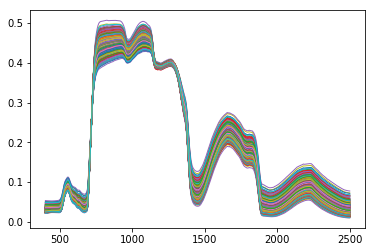

In [30]:
plt.plot(Soil[0], np.array(all_leaf_array[0]).T, label = 'Reflectance', linewidth=1);
